# Análisis de relación entre engagement y toxicidad con modelos de regresión

Vamos a usar OLS, Poisson y Negative Binomial para analizar la relación entre el engagement y la toxicidad.

In [1]:
import pandas as pd

df = pd.read_csv("../data/comentarios_analizados.csv")

df.drop({"Unnamed: 0", "TOXICITY"}, axis=1, inplace=True)
df.rename({"text_x":"text"}, axis=1, inplace=True)

df.drop_duplicates(subset ='text', keep = False, inplace = True)
df = df.loc[df.canal != "Nimu"]

df.canal.value_counts()

canal
NICO VILLA                313198
Romi                      212981
PassThor                  209330
Tincho Ruiz                90509
maritobaracus              73837
FFran Gomez                43708
Hecatombe Producciones     41661
AleVera Oficial            37155
Guille Aquino              32719
Rodriguez Galati           31112
Melina Vallejos            18171
SimpDNimu                    686
Name: count, dtype: int64

Binarizo todo de acuerdo al threshold

In [2]:
toxicity_fields = [
    "toxicity",
    "THREAT_EXPERIMENTAL",
    "IDENTITY_ATTACK_EXPERIMENTAL",
    "INSULT_EXPERIMENTAL",
    "PROFANITY_EXPERIMENTAL",
    "SEVERE_TOXICITY",
]

engagement_fields = [
    'replyCount', 'likeCount', 'likes_video', 'vistas_video', 'cantidad_comentarios'
]

threshold = 0.8

df.loc[:, toxicity_fields] = df.loc[:, toxicity_fields] > threshold



/tmp/ipykernel_25066/4268570588.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False  True False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, toxicity_fields] = df.loc[:, toxicity_fields] > threshold
/tmp/ipykernel_25066/4268570588.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:, toxicity_fields] = df.loc[:, toxicity_fields] > threshold
/tmp/ipykernel_25066/4268570588.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype 

Hasta acá, df es de comentarios, ahora con los valores binarizados.

Queremos un df por video 

Tomo la suma en el caso de los replyCounts y likeCounts (son a nivel comentario) y el primero para cada video

**CHEQUEAR ESTO!**

In [3]:
df_video = df.groupby("videoId").agg({
    **{k:"mean" for k in toxicity_fields},
    **{k:"sum" for k in ['replyCount', 'likeCount']},
    **{k:"first" for k in ['likes_video', 'vistas_video', 'cantidad_comentarios', 'canal']}
})

In [4]:
df_video["canal"].unique()

array(['Rodriguez Galati', 'NICO VILLA', 'maritobaracus', 'FFran Gomez',
       'AleVera Oficial', 'Tincho Ruiz', 'Romi', 'PassThor',
       'Hecatombe Producciones', 'Melina Vallejos', 'SimpDNimu',
       'Guille Aquino'], dtype=object)

In [5]:
import numpy as np

youtubers = df_video["canal"].unique()
zscore_fields = toxicity_fields

for field in zscore_fields:
    zscore_name = "z_" + field
    print(field)
    for youtuber in youtubers:
        values = df_video.loc[df_video["canal"] == youtuber, field]
        mean = values.mean()
        std = values.std()
        df_video.loc[df_video["canal"] == youtuber, zscore_name] = ((values - mean) / std).values

for field in engagement_fields:
    log_name = "log_" + field
    df_video[log_name] = np.log(df_video[field])



toxicity
THREAT_EXPERIMENTAL
IDENTITY_ATTACK_EXPERIMENTAL
INSULT_EXPERIMENTAL
PROFANITY_EXPERIMENTAL
SEVERE_TOXICITY


In [6]:
df_video.columns

Index(['toxicity', 'THREAT_EXPERIMENTAL', 'IDENTITY_ATTACK_EXPERIMENTAL',
       'INSULT_EXPERIMENTAL', 'PROFANITY_EXPERIMENTAL', 'SEVERE_TOXICITY',
       'replyCount', 'likeCount', 'likes_video', 'vistas_video',
       'cantidad_comentarios', 'canal', 'z_toxicity', 'z_THREAT_EXPERIMENTAL',
       'z_IDENTITY_ATTACK_EXPERIMENTAL', 'z_INSULT_EXPERIMENTAL',
       'z_PROFANITY_EXPERIMENTAL', 'z_SEVERE_TOXICITY', 'log_replyCount',
       'log_likeCount', 'log_likes_video', 'log_vistas_video',
       'log_cantidad_comentarios'],
      dtype='object')

In [7]:
column_order = [
    'replyCount', 'likeCount', 'likes_video', 'vistas_video',
    'cantidad_comentarios', 'canal', 'log_replyCount',
    'log_likeCount', 'log_likes_video', 'log_vistas_video',
    'log_cantidad_comentarios',
    'toxicity', 'THREAT_EXPERIMENTAL', 'IDENTITY_ATTACK_EXPERIMENTAL',
    'INSULT_EXPERIMENTAL', 'PROFANITY_EXPERIMENTAL', 'SEVERE_TOXICITY',
    'z_toxicity', 'z_THREAT_EXPERIMENTAL',
    'z_IDENTITY_ATTACK_EXPERIMENTAL', 'z_INSULT_EXPERIMENTAL',
    'z_PROFANITY_EXPERIMENTAL', 'z_SEVERE_TOXICITY',
]

df_video = df_video.reindex(columns=column_order)

## Efectos fijos

Agrego variables dummy para los efectos fijos por autor

In [8]:
data = df_video.copy()

autores = data.canal.value_counts().keys()

dummy_columns = [f"dummy_{canal}" for canal in autores]

for autor in autores:
    col_name = f"dummy_{autor}"
    data[col_name] = data.canal.apply(lambda x: 1 if x == autor else 0)

assert all(data.loc[:, dummy_columns].sum(axis=1) == 1)

In [9]:

import seaborn as sns
import matplotlib.pyplot as plt


toxicity_fields = [
    "toxicity",
    "THREAT_EXPERIMENTAL",
    "IDENTITY_ATTACK_EXPERIMENTAL",
    "INSULT_EXPERIMENTAL",
    "PROFANITY_EXPERIMENTAL",
    "SEVERE_TOXICITY",
]

engagement_fields = [
    'replyCount', 'likeCount', 'likes_video', 'vistas_video', 'cantidad_comentarios'
]


'\nfor toxicity_field in toxicity_fields:\n    for engagement_field in engagement_fields:\n        plt.figure(figsize=(5,5))\n        plt.semilogy()\n        sns.scatterplot(y=engagement_field, x=toxicity_field, data=data, hue="canal")\n'

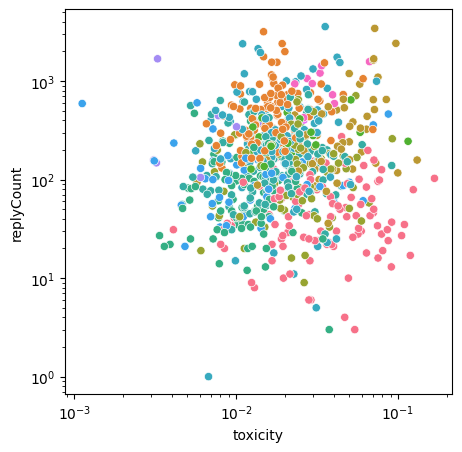

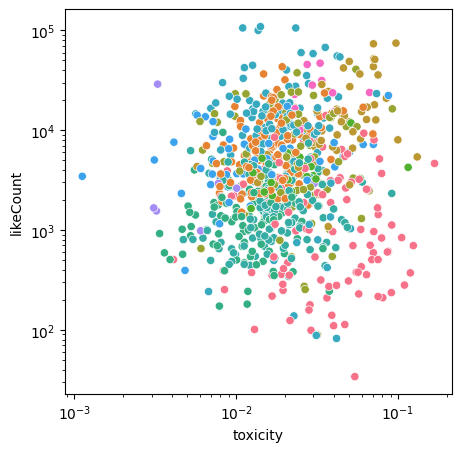

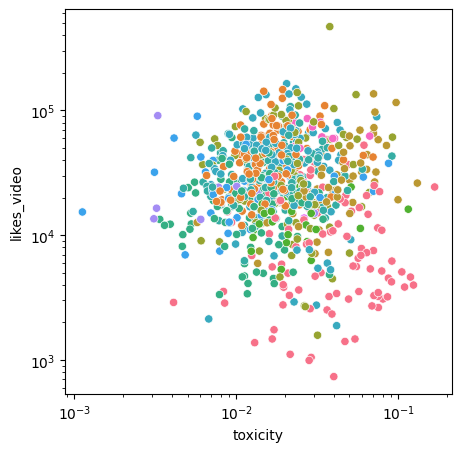

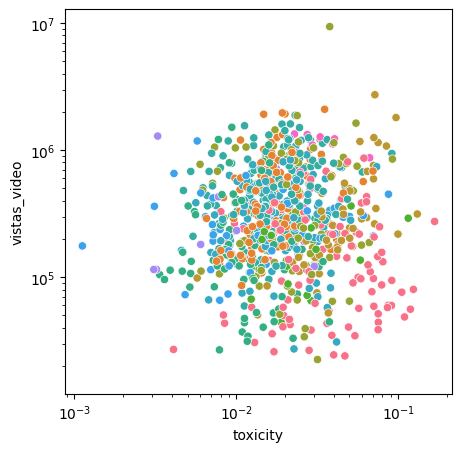

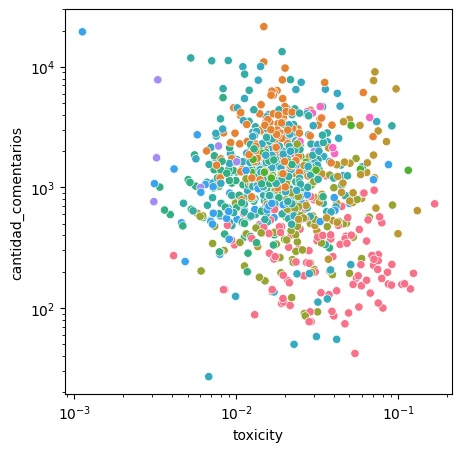

In [12]:

for toxicity_field in ["toxicity"]:
    for engagement_field in engagement_fields:
        plt.figure(figsize=(5,5))
        plt.semilogy()
        plt.semilogx()
        sns.scatterplot(y=engagement_field, x=toxicity_field, data=data, hue="canal", legend=False)


## Primer experimento

Reducimos dispersión con log(Y) y usamos OLS

Nuestras muestras son medio right-skewed... aplicar log no es necesariamente tan horrible ([ver acá](https://files.alz.washington.edu/presentations/2020/fall/Malek-Ahmadi.pdf))



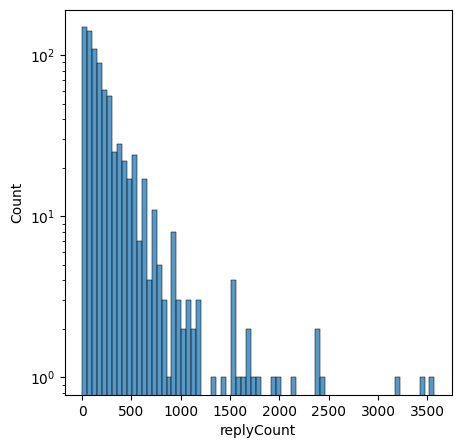

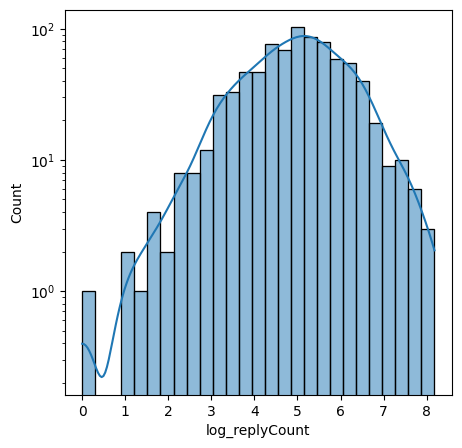

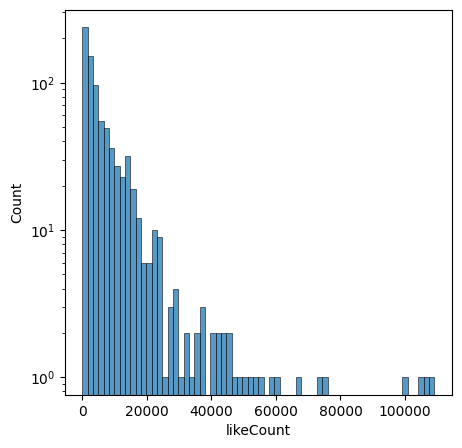

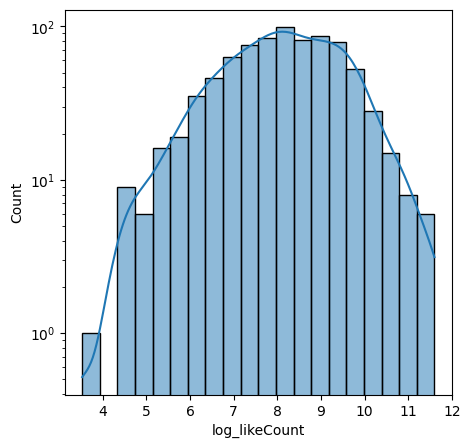

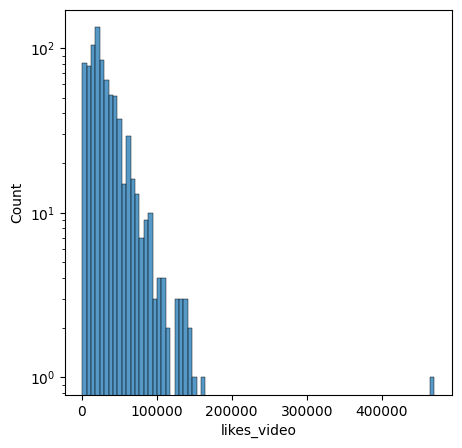

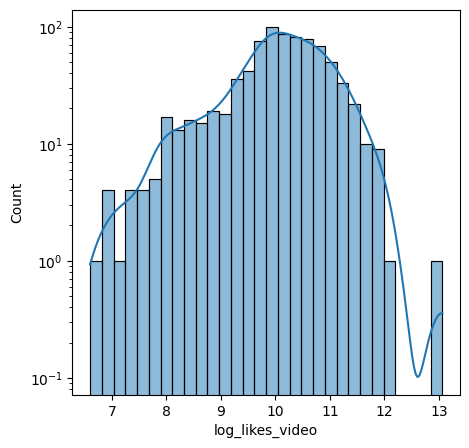

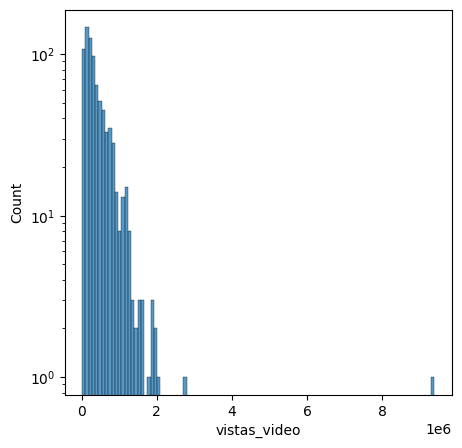

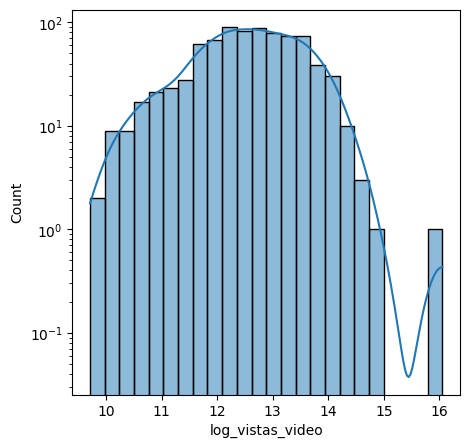

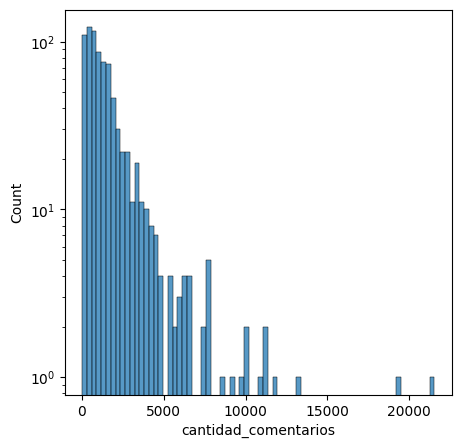

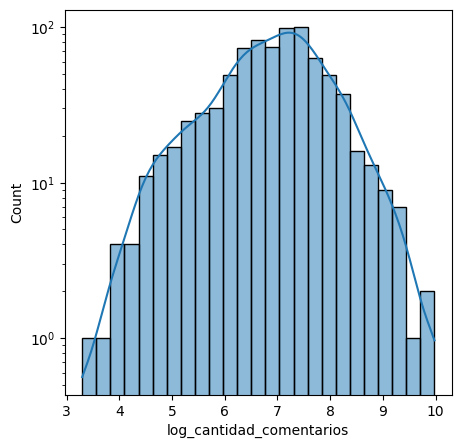

In [86]:
from scipy.stats import shapiro
for engagement_field in engagement_fields:
    plt.figure(figsize=(5,5))
    plt.semilogy()
    sns.histplot(data[engagement_field])

    plt.figure(figsize=(5,5))
    plt.semilogy()
    sns.histplot(np.log(data[engagement_field]), kde=True)
    plt.xlabel(f"log_{engagement_field}")


No son normales pero... tampoco están taaaaaaaan mal

### Sin efectos fijos

In [16]:
import statsmodels.api as sm

input_variables = [
    "toxicity"
]

for engagement_field in engagement_fields:
    print("="*80)
    print("\n"*4)
    print(f"Engagement field: {engagement_field}")
    X = data[input_variables]

    # Usamos un intercept igual para todos
    X = sm.add_constant(X)
    y = np.log(data[engagement_field])

    model = sm.OLS(y, X)

    results = model.fit()

    print(results.summary())








Engagement field: replyCount
                            OLS Regression Results                            
Dep. Variable:             replyCount   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.04642
Date:                Fri, 05 Apr 2024   Prob (F-statistic):              0.829
Time:                        12:42:49   Log-Likelihood:                -1274.9
No. Observations:                 811   AIC:                             2554.
Df Residuals:                     809   BIC:                             2563.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9

                             OLS Regression Results                             
Dep. Variable:     cantidad_comentarios   R-squared:                       0.029
Model:                              OLS   Adj. R-squared:                  0.028
Method:                   Least Squares   F-statistic:                     24.50
Date:                  Fri, 05 Apr 2024   Prob (F-statistic):           9.04e-07
Time:                          12:42:49   Log-Likelihood:                -1165.0
No. Observations:                   811   AIC:                             2334.
Df Residuals:                       809   BIC:                             2343.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.1227      0.057

Los r-squared son bastante bajos...

### Con efectos fijos

In [20]:


import statsmodels.api as sm

for engagement_field in engagement_fields:
    print("*"*80)
    print("*"*80)
    print("\n"*4)
    print(f"Engagement field: {engagement_field}")
    # Las dummy columns son indicadoras de cada grupo

    X = data[input_variables + dummy_columns]
    X = sm.add_constant(X)
    y = np.log(data[engagement_field])

    model = sm.OLS(y, X)

    results = model.fit()

    print(results.summary())

    print("\n"*4)



********************************************************************************
********************************************************************************





Engagement field: replyCount
                            OLS Regression Results                            
Dep. Variable:             replyCount   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     57.64
Date:                Fri, 05 Apr 2024   Prob (F-statistic):           1.30e-99
Time:                        12:44:03   Log-Likelihood:                -1021.8
No. Observations:                 811   AIC:                             2070.
Df Residuals:                     798   BIC:                             2131.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
              

## Experimento 2: Regresión de Poisson


Acá tengo una duda de que esto funcione bien: las hipótesis de Poisson no se cumplen ni a palos (varianza = media, principalmente). Acá va una pruebita

In [21]:
for engagement_field in engagement_fields:
    # Media
    print(f"Engagement field: {engagement_field}")
    mean = data[engagement_field].mean()
    var = data[engagement_field].var()

    print(f"Mean: {mean}")
    print(f"Var: {var}")


Engagement field: replyCount
Mean: 271.10850801479654
Var: 141527.4647546848
Engagement field: likeCount
Mean: 7530.721331689272
Var: 141450259.59385303
Engagement field: likes_video
Mean: 32895.31689272503
Var: 913594121.6932822
Engagement field: vistas_video
Mean: 420679.4907521578
Var: 228399976167.0453
Engagement field: cantidad_comentarios
Mean: 1616.7644882860666
Var: 3763344.07162625


Me parece que no es buena idea... y da mal de hecho! Fijate que son significativos pero el R^2 da horrible

In [22]:


import statsmodels.api as sm

for engagement_field in engagement_fields:
    print("*"*80)
    print("*"*80)
    print("\n"*4)
    print(f"Engagement field: {engagement_field}")
    # Las dummy columns son indicadoras de cada grupo

    X = data[input_variables]

    X = sm.add_constant(X)

    # No aplicamos log...
    y = data[engagement_field]

    model = sm.Poisson(y, X)

    results = model.fit()

    print(results.summary())

    print("\n"*4)



********************************************************************************
********************************************************************************





Engagement field: replyCount
Optimization terminated successfully.
         Current function value: 159.257926
         Iterations 5
                          Poisson Regression Results                          
Dep. Variable:             replyCount   No. Observations:                  811
Model:                        Poisson   Df Residuals:                      809
Method:                           MLE   Df Model:                            1
Date:                Fri, 05 Apr 2024   Pseudo R-squ.:                0.008533
Time:                        12:44:19   Log-Likelihood:            -1.2916e+05
converged:                       True   LL-Null:                   -1.3027e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025  

In [26]:


import statsmodels.api as sm

for engagement_field in engagement_fields:
    print("*"*80)
    print("*"*80)
    print("\n"*4)
    print(f"Engagement field: {engagement_field}")
    # Las dummy columns son indicadoras de cada grupo

    X = data[input_variables + dummy_columns]

    X = sm.add_constant(X)

    # No aplicamos log...
    y = data[engagement_field]

    model = sm.Poisson(y, X)

    results = model.fit()

    print(results.summary())

    print("\n"*4)



********************************************************************************
********************************************************************************





Engagement field: replyCount
         Current function value: 90.761233
         Iterations: 35


/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                          Poisson Regression Results                          
Dep. Variable:             replyCount   No. Observations:                  811
Model:                        Poisson   Df Residuals:                      798
Method:                           MLE   Df Model:                           12
Date:                Fri, 05 Apr 2024   Pseudo R-squ.:                  0.4350
Time:                        12:47:47   Log-Likelihood:                -73607.
converged:                      False   LL-Null:                   -1.3027e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            5.2749   1.04e+05   5.08e-05      1.000   -2.04e+05    2.04e+05
toxicity                        11.2186      0.127     88.126      0.000     

/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 7037.131534
         Iterations: 35
                          Poisson Regression Results                          
Dep. Variable:            likes_video   No. Observations:                  811
Model:                        Poisson   Df Residuals:                      798
Method:                           MLE   Df Model:                           12
Date:                Fri, 05 Apr 2024   Pseudo R-squ.:                  0.3059
Time:                        12:47:48   Log-Likelihood:            -5.7071e+06
converged:                      False   LL-Null:                   -8.2219e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           10.1202   3.75e+04      0.000      1.000   -7.35e+04    7.35e+04
toxicity

/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                          Poisson Regression Results                          
Dep. Variable:           vistas_video   No. Observations:                  811
Model:                        Poisson   Df Residuals:                      798
Method:                           MLE   Df Model:                           12
Date:                Fri, 05 Apr 2024   Pseudo R-squ.:                  0.2365
Time:                        12:47:48   Log-Likelihood:            -9.8621e+07
converged:                      False   LL-Null:                   -1.2916e+08
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           12.7131   5115.313      0.002      0.998      -1e+04       1e+04
toxicity                         7.9780      0.003   2434.883      0.000     

/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Tercer experimento: Binomial negativa

In [27]:



import statsmodels.api as sm

for engagement_field in engagement_fields:
    print("*"*80)
    print("*"*80)
    print("\n"*4)
    print(f"Engagement field: {engagement_field}")
    # Las dummy columns son indicadoras de cada grupo

    X = data[input_variables]

    X = sm.add_constant(X)

    # No aplicamos log...
    y = data[engagement_field]

    model = sm.NegativeBinomial(y, X)

    results = model.fit()

    print(results.summary())

    print("\n"*4)



********************************************************************************
********************************************************************************





Engagement field: replyCount
Optimization terminated successfully.
         Current function value: 6.597777
         Iterations: 11
         Function evaluations: 16
         Gradient evaluations: 16
                     NegativeBinomial Regression Results                      
Dep. Variable:             replyCount   No. Observations:                  811
Model:               NegativeBinomial   Df Residuals:                      809
Method:                           MLE   Df Model:                            1
Date:                Fri, 05 Apr 2024   Pseudo R-squ.:               0.0008015
Time:                        12:47:56   Log-Likelihood:                -5350.8
converged:                       True   LL-Null:                       -5355.1
Covariance Type:            nonrobust   LLR p-value:                  0.003392


Optimization terminated successfully.
         Current function value: 11.347038
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
                     NegativeBinomial Regression Results                      
Dep. Variable:            likes_video   No. Observations:                  811
Model:               NegativeBinomial   Df Residuals:                      809
Method:                           MLE   Df Model:                            1
Date:                Fri, 05 Apr 2024   Pseudo R-squ.:               3.755e-07
Time:                        12:47:56   Log-Likelihood:                -9202.4
converged:                       True   LL-Null:                       -9202.5
Covariance Type:            nonrobust   LLR p-value:                    0.9337
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.4043      0.048    2

In [64]:



import statsmodels.api as sm

for engagement_field in engagement_fields:
    print("*"*80)
    print("*"*80)
    print("\n"*4)
    print(f"Engagement field: {engagement_field}")
    # Las dummy columns son indicadoras de cada grupo

    X = data[input_variables + dummy_columns]

    X = sm.add_constant(X)

    # No aplicamos log...
    y = data[engagement_field]

    model = sm.NegativeBinomial(y, X)

    results = model.fit()

    print(results.summary())

    print("\n"*4)



********************************************************************************
********************************************************************************





Engagement field: replyCount


/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 6.248438
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                     NegativeBinomial Regression Results                      
Dep. Variable:             replyCount   No. Observations:                  811
Model:               NegativeBinomial   Df Residuals:                      798
Method:                           MLE   Df Model:                           12
Date:                Fri, 05 Apr 2024   Pseudo R-squ.:                 0.05371
Time:                        12:14:01   Log-Likelihood:                -5067.5
converged:                      False   LL-Null:                       -5355.1
Covariance Type:            nonrobust   LLR p-value:                2.074e-115
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            5.3584 

/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 9.510341
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                     NegativeBinomial Regression Results                      
Dep. Variable:              likeCount   No. Observations:                  811
Model:               NegativeBinomial   Df Residuals:                      798
Method:                           MLE   Df Model:                           12
Date:                Fri, 05 Apr 2024   Pseudo R-squ.:                 0.03871
Time:                        12:14:01   Log-Likelihood:                -7712.9
converged:                      False   LL-Null:                       -8023.4
Covariance Type:            nonrobust   LLR p-value:                3.307e-125
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            8.6423 

/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 11.148016
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                     NegativeBinomial Regression Results                      
Dep. Variable:            likes_video   No. Observations:                  811
Model:               NegativeBinomial   Df Residuals:                      798
Method:                           MLE   Df Model:                           12
Date:                Fri, 05 Apr 2024   Pseudo R-squ.:                 0.01754
Time:                        12:14:02   Log-Likelihood:                -9041.0
converged:                      False   LL-Null:                       -9202.5
Covariance Type:            nonrobust   LLR p-value:                 7.489e-62
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           10.1622

/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/jmperez/projects/odio

         Current function value: 13.771498
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                     NegativeBinomial Regression Results                      
Dep. Variable:           vistas_video   No. Observations:                  811
Model:               NegativeBinomial   Df Residuals:                      798
Method:                           MLE   Df Model:                           12
Date:                Fri, 05 Apr 2024   Pseudo R-squ.:                 0.01061
Time:                        12:14:02   Log-Likelihood:                -11169.
converged:                      False   LL-Null:                       -11288.
Covariance Type:            nonrobust   LLR p-value:                 2.052e-44
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           12.7332

### Con efectos fijos

In [29]:



import statsmodels.api as sm

for engagement_field in engagement_fields:
    print("*"*80)
    print("*"*80)
    print("\n"*4)
    print(f"Engagement field: {engagement_field}")
    # Las dummy columns son indicadoras de cada grupo

    X = data[input_variables + dummy_columns]

    X = sm.add_constant(X)
    # No aplicamos log...
    y = data[engagement_field]

    model = sm.NegativeBinomial(y, X, maxiter=1000)

    results = model.fit()

    print(results.summary())

    print("\n"*4)



********************************************************************************
********************************************************************************





Engagement field: replyCount


/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['maxiter']
  warnings.warn(msg, ValueWarning)
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['maxiter']
  warnings.warn(msg, ValueWarning)
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['maxiter']
  warnings.warn(msg, V

         Current function value: 6.248438
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                     NegativeBinomial Regression Results                      
Dep. Variable:             replyCount   No. Observations:                  811
Model:               NegativeBinomial   Df Residuals:                      798
Method:                           MLE   Df Model:                           12
Date:                Fri, 05 Apr 2024   Pseudo R-squ.:                 0.05371
Time:                        12:49:17   Log-Likelihood:                -5067.5
converged:                      False   LL-Null:                       -5355.1
Covariance Type:            nonrobust   LLR p-value:                2.074e-115
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            5.3584 

/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['maxiter']
  warnings.warn(msg, ValueWarning)
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['maxiter']
  warnings.warn(msg, ValueWarning)


         Current function value: 9.510341
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                     NegativeBinomial Regression Results                      
Dep. Variable:              likeCount   No. Observations:                  811
Model:               NegativeBinomial   Df Residuals:                      798
Method:                           MLE   Df Model:                           12
Date:                Fri, 05 Apr 2024   Pseudo R-squ.:                 0.03871
Time:                        12:49:18   Log-Likelihood:                -7712.9
converged:                      False   LL-Null:                       -8023.4
Covariance Type:            nonrobust   LLR p-value:                3.307e-125
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            8.6423 

/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['maxiter']
  warnings.warn(msg, ValueWarning)
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model

         Current function value: 11.148016
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                     NegativeBinomial Regression Results                      
Dep. Variable:            likes_video   No. Observations:                  811
Model:               NegativeBinomial   Df Residuals:                      798
Method:                           MLE   Df Model:                           12
Date:                Fri, 05 Apr 2024   Pseudo R-squ.:                 0.01754
Time:                        12:49:18   Log-Likelihood:                -9041.0
converged:                      False   LL-Null:                       -9202.5
Covariance Type:            nonrobust   LLR p-value:                 7.489e-62
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           10.1622

/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['maxiter']
  warnings.warn(msg, ValueWarning)
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model

         Current function value: 13.771498
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                     NegativeBinomial Regression Results                      
Dep. Variable:           vistas_video   No. Observations:                  811
Model:               NegativeBinomial   Df Residuals:                      798
Method:                           MLE   Df Model:                           12
Date:                Fri, 05 Apr 2024   Pseudo R-squ.:                 0.01061
Time:                        12:49:19   Log-Likelihood:                -11169.
converged:                      False   LL-Null:                       -11288.
Covariance Type:            nonrobust   LLR p-value:                 2.052e-44
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           12.7332

/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/scipy/optimize/_optimize.py:1292: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/jmperez/projects/odiogarpa/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['maxiter']
  warnings.warn(msg, ValueWarning)
